# Introduction to atomman: LAMMPS functionality

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

## 1. Introduction

This Notebook provides an introduction to interacting with LAMMPS using atomman by working through a demonstration simulation.

**Library Imports**

In [1]:
# Standard libraries
from __future__ import (absolute_import, print_function,
                        division, unicode_literals)
import os
import datetime

# http://www.numpy.org/
import numpy as np             

# http://matplotlib.org/
import matplotlib.pyplot as plt 
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am            
import atomman.lammps as lmp
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.2.7
Notebook executed on 2019-06-05


## 2. Interatomic Potential Control

LAMMPS is capable of using a wide array of interatomic potential styles, which are defined through a combination of LAMMPS commands and potential parameter files.  In atomman, the LAMMPS commands can be automatically generated using the Potentials class and structured data model files (Section 2.2).

### 2.1 MEAM parameter files

This generates the library and parameter files for the 2015--Pascuet-M-I--Al potential. It serves as a nice demonstration as the parameter files are short compared to other potentials allowing them to be embedded in this Notebook.

In [2]:
# Generate Al.meam parameter file
with open('Al.meam', 'w') as f:
    f.write("""re(1,1) =   2.86378
attrac(1,1) = 0.39558
repuls(1,1) = 0.09806
Cmin(1,1,1) = 1.00769
Cmax(1,1,1) = 2.31407
#
rc = 5.0
delr = 0.1
augt1 = 1""")

In [3]:
# Generate library-Al.meam parameter file
with open('library-Al.meam', 'w') as f:
    f.write("""# References:
# elt        lat     z       ielement     atwt
# alpha      b0      b1      b2           b3    alat    esub    asub
# t0         t1              t2           t3            rozero  ibar
#
'Al'        'fcc'   12.     13           26.9815
  4.68604   1.56205   5.39270   5.29601  -1.00047   4.05000   3.35999   1.06859
1.0  -1.54917  -1.28508  10.01041 1.0 0 """)

### 2.2 potential-LAMMPS data model file

This generates the data model associated with the potential above. The different fields of the model depict values that are used to generate the LAMMPS command lines associated with the potential.

See [03.1 Potential class Jupyter Notebook](03.1 Potential class.ipynb) for more details on the data model format.

In [4]:
# Data model corresponding to the potential parameter files above 
with open('2015--Pascuet-M-I--Al--LAMMPS--ipr1.json', 'w') as f:
    f.write("""{
    "potential-LAMMPS": {
        "key": "83ca7343-12d3-4644-b85b-2b3a839f884e", 
        "id": "2015--Pascuet-M-I--Al--LAMMPS--ipr1", 
        "potential": {
            "key": "b5fb2f1f-a582-4f81-9445-f002ce31e66e", 
            "id": "2015--Pascuet-M-I--Al"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "element": "Al", 
                "mass": 26.9815
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "library-Al.meam"
                }, 
                {
                    "option": "Al"
                }, 
                {
                    "file": "Al.meam"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")

### 2.3 lammps.Potential Class

The data model can then be read in and interpreted using a lammps.Potential object.  This allows for the generation of dynamic LAMMPS command lines for the potential.

In [5]:
# Read in potential data model during initialization
potential = lmp.Potential('2015--Pascuet-M-I--Al--LAMMPS--ipr1.json')

Basic properties can be directly obtained.

In [6]:
# Show that basic properties can be directly obtained
print('str(potential) ->       ', potential)
print('potential.units ->      ', potential.units)
print('potential.atom_style -> ', potential.atom_style)
print('potential.pair_style -> ', potential.pair_style)
print('potential.symbols ->    ', potential.symbols)
print('potential.elements() -> ', potential.elements())
print('potential.masses() ->   ', potential.masses())

str(potential) ->        2015--Pascuet-M-I--Al--LAMMPS--ipr1
potential.units ->       metal
potential.atom_style ->  atomic
potential.pair_style ->  meam
potential.symbols ->     ['Al']
potential.elements() ->  ['Al']
potential.masses() ->    [26.9815]


The LAMMPS command lines for the potential are auto-generated based on a list of symbols corresponding to LAMMPS atom types. This fully works for all LAMMPS pair_styles, with only the hybrid and hybrid/overlay styles having limitations.

In [7]:
print('potential.pair_info() ->')
print(potential.pair_info())
print()

print("potential.pair_info(['Al', 'Al', 'Al']) ->")
print(potential.pair_info(['Al', 'Al', 'Al']))

potential.pair_info() ->
mass 1 26.981500

pair_style meam
pair_coeff * * library-Al.meam Al Al.meam Al


potential.pair_info(['Al', 'Al', 'Al']) ->
mass 1 26.981500
mass 2 26.981500
mass 3 26.981500

pair_style meam
pair_coeff * * library-Al.meam Al Al.meam Al Al Al



## 3. Generate initial system

### 3.1 Load poscar Al fcc unit cell

A crystalline system can be easily generated using a unit cell system either defined in atomman or imported from another format.  For simplicity, here we will load a unit cell from a poscar file.

In [8]:
# Generate poscar file
with open('Al-fcc.poscar', 'w') as f:
    f.write("""POSCAR for fcc Al standard unit cell
1.0
4.05 0.00 0.00
0.00 4.05 0.00
0.00 0.00 4.05
Al
4 
direct
0.00 0.00 0.00
0.50 0.50 0.00
0.50 0.00 0.50
0.00 0.50 0.50""")

Load poscar file to an atomman.System

In [9]:
system = am.load('poscar', 'Al-fcc.poscar')
print(system)

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   2.025 |   2.025 |   0.000
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   0.000 |   2.025 |   2.025


### 3.2 Manipulate system

More complicated atomic configurations can then be generated by manipulating the seed system and the atoms contained within. Here, we'll limit the manipulations to making the system a 3x3x3 supercell of itself.

In [10]:
system = system.supersize(3,3,3)
print('Supercell has', system.natoms, 'atoms')

Supercell has 108 atoms


### 3.3 Save to atom data file

System.dump('atom_data') outputs the system to a LAMMPS atom data file. The parameters of the method with this style:

- **style** is the output format to use ('atom_data' here).

- **f** is a file path or file-like object to write to. If not given, the generated content is returned.

- **units** is the LAMMPS units option to use for values. Default value is 'metal'.

- **atom_style** is the LAMMPS atom_style option to use for the file. Default value is 'atomic'.

- **float_format** allows the c-style format of floating point values to be specified. Default value is '%.13f'.

- **return_info** is a bool indicating if the LAMMPS command lines for reading in the generated file are to be returned.  Default value is True. 

In [11]:
# Save System to 'atom.dat' atom data file 
system_info = system.dump('atom_data', f='atom.dat',
                          units=potential.units, 
                          atom_style=potential.atom_style,
                          float_format='%.4f')

Show the returned LAMMPS command lines

In [12]:
print(system_info)

# Script and atom data file prepared by atomman package

units metal
atom_style atomic
boundary p p p 
read_data atom.dat


Show the contents of the data file

In [13]:
with open('atom.dat') as f:
    print(f.read())


108 atoms
1 atom types
0.0000 12.1500 xlo xhi
0.0000 12.1500 ylo yhi
0.0000 12.1500 zlo zhi

Atoms

1 1 0.0000 0.0000 0.0000
2 1 2.0250 2.0250 0.0000
3 1 2.0250 0.0000 2.0250
4 1 0.0000 2.0250 2.0250
5 1 4.0500 0.0000 0.0000
6 1 6.0750 2.0250 0.0000
7 1 6.0750 0.0000 2.0250
8 1 4.0500 2.0250 2.0250
9 1 8.1000 0.0000 0.0000
10 1 10.1250 2.0250 0.0000
11 1 10.1250 0.0000 2.0250
12 1 8.1000 2.0250 2.0250
13 1 0.0000 4.0500 0.0000
14 1 2.0250 6.0750 0.0000
15 1 2.0250 4.0500 2.0250
16 1 0.0000 6.0750 2.0250
17 1 4.0500 4.0500 0.0000
18 1 6.0750 6.0750 0.0000
19 1 6.0750 4.0500 2.0250
20 1 4.0500 6.0750 2.0250
21 1 8.1000 4.0500 0.0000
22 1 10.1250 6.0750 0.0000
23 1 10.1250 4.0500 2.0250
24 1 8.1000 6.0750 2.0250
25 1 0.0000 8.1000 0.0000
26 1 2.0250 10.1250 0.0000
27 1 2.0250 8.1000 2.0250
28 1 0.0000 10.1250 2.0250
29 1 4.0500 8.1000 0.0000
30 1 6.0750 10.1250 0.0000
31 1 6.0750 8.1000 2.0250
32 1 4.0500 10.1250 2.0250
33 1 8.1000 8.1000 0.0000
34 1 10.1250 10.1250 0.0000
35 1 10.1250 8

## 4. Converting to/from LAMMPS units

LAMMPS performs its calculations with values in one of multiple sets of pre-defined units.  The atomman.lammps.style submodule has some useful functions when working with different units options.

**atomman.lammps.style.timestep()**

The lammps.style.timestep() function returns the default timestep value for a given LAMMPS units option.

Parameters

- **units** (*str*) the LAMMPS units option being used.

**atomman.lammps.style.unit()**

The lammps.style.unit() function returns a dictionary giving the units associated with physical quantities as used by LAMMPS with a given units option.

Parameters

- **units** (*str*) the LAMMPS units option being used.

In [14]:
timestep = lmp.style.timestep(potential.units)
print(timestep)

0.001


In [15]:
lammps_unit = lmp.style.unit(potential.units)
print(lammps_unit)

OrderedDict([('mass', 'g/mol'), ('length', 'angstrom'), ('time', 'ps'), ('energy', 'eV'), ('velocity', 'angstrom/ps'), ('force', 'eV/angstrom'), ('torque', 'eV'), ('temperature', 'K'), ('pressure', 'bar'), ('dynamic viscosity', 'Pa*s/10'), ('charge', 'e'), ('dipole', 'e*angstrom'), ('electric field', 'V/angstrom'), ('density', 'g/cm^3'), ('ang-mom', 'angstrom*angstrom/ps*g/mol'), ('ang-vel', '1/ps')])


## 5. Composing LAMMPS Input Scripts

LAMMPS scripts can easily be constructed by combining the system_info generated from System.dump('atom_data'), the pair_info from Potential.pair_info(), and any user-defined input lines.  This allows for specific simulation actions to easily be perfored across different potentials or initial configurations.

### 5.1 Show content generated in previous sections

Show system_info generated in Section 3.3.

In [16]:
print(system_info)

# Script and atom data file prepared by atomman package

units metal
atom_style atomic
boundary p p p 
read_data atom.dat


Generate pair_info using potential object created in Section 2.3 with the list of symbols from Section 3.1

In [17]:
pair_info = potential.pair_info(system.symbols)
print(pair_info)

mass 1 26.981500

pair_style meam
pair_coeff * * library-Al.meam Al Al.meam Al



### 5.2 Write LAMMPS input script template

LAMMPS scripts can be dynamically generated using Python functions or templates that take the above info lines and other values as parameters. Here, we demonstrate a LAMMPS input template script where all fields to be filled in in Python are delimited with <> brackets.

In [18]:
template = """
<system_info>

<pair_info>

# Define temperature and dependent variables
variable T equal <temperature>
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal <pressure>

# Define timestep and dependent variables
variable deltat equal <timestep>
variable Trelax equal 100*${deltat}
variable Prelax equal 1000*${deltat}

# Initialize atomic velocities with twoT
velocity all create ${twoT} 124352

# Define thermo steps and properties
thermo 100
thermo_style custom step temp press lx ly lz

# Define dump 
dump mydump all atom 100000 *.dump

# Specify timestep
timestep ${deltat}

# Apply npt conditions
fix 1 all npt temp $T $T ${Trelax} iso $P $P ${Prelax}

# Run simulation
run 100000
"""           

### 5.3 Fill in the template with atomman.tools.filltemplate()

The template can then be easily filled in with the atomman.tools.filltemplate() function. 

Parameters

- **template** (*str or file-like object*) is the template to fill in.

- **variable** (*dict*) gives the delimited keys and corresponding values to insert into the template.

- **s_delimiter** (*str*) the starting delimiter for identifying variable names.

- **e_delimiter** (*str*) the ending delimiter for identifying variable names.

Build dictionary of template variables

In [19]:
lammps_variable = {}

# Generated above
lammps_variable['system_info'] = system_info
lammps_variable['pair_info'] = pair_info

# Set timestep to default value for LAMMPS units
lammps_variable['timestep'] = lmp.style.timestep(units=potential.units)

# Specify temperature to equilibriate at (always in Kelvin)
lammps_variable['temperature'] = 100

# Specify pressure to equilibriate at
pressure = uc.set_in_units(0.0, 'MPa')
lammps_variable['pressure'] = uc.get_in_units(pressure, lammps_unit['pressure'])

print(lammps_variable)

{'system_info': '# Script and atom data file prepared by atomman package\n\nunits metal\natom_style atomic\nboundary p p p \nread_data atom.dat', 'pair_info': 'mass 1 26.981500\n\npair_style meam\npair_coeff * * library-Al.meam Al Al.meam Al\n', 'timestep': 0.001, 'temperature': 100, 'pressure': 0.0}


Fill in template

In [20]:
# Generate script from template and lammps_variable
script = am.tools.filltemplate(template, lammps_variable, '<', '>')

# Save script to 'nvt.in'
with open('nvt.in', 'w') as f:
    f.write(script)

# Show contents of 'nvt.in'    
with open('nvt.in') as f:
    print(f.read())


# Script and atom data file prepared by atomman package

units metal
atom_style atomic
boundary p p p 
read_data atom.dat

mass 1 26.981500

pair_style meam
pair_coeff * * library-Al.meam Al Al.meam Al


# Define temperature and dependent variables
variable T equal 100
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal 0.0

# Define timestep and dependent variables
variable deltat equal 0.001
variable Trelax equal 100*${deltat}
variable Prelax equal 1000*${deltat}

# Initialize atomic velocities with twoT
velocity all create ${twoT} 124352

# Define thermo steps and properties
thermo 100
thermo_style custom step temp press lx ly lz

# Define dump 
dump mydump all atom 100000 *.dump

# Specify timestep
timestep ${deltat}

# Apply npt conditions
fix 1 all npt temp $T $T ${Trelax} iso $P $P ${Prelax}

# Run simulation
run 100000



## 6. Run LAMMPS

The LAMMPS simulation can be ran from within Python using the run() function.

Specify your lammps executable

In [21]:
lammps_exe = 'lmp_serial'

Run the simulation 

In [22]:
output = lmp.run(lammps_exe, 'nvt.in', return_style='object')

The resulting simulation data is returned as a Log object, which containes the thermo data from the log.lammps files. 

## 7. Analyzing Thermo Results

Data for each run/minimization is stored in in a list of dictionaries called simulations in the returned Log file.  In each dictionary, there is a thermo key that represents a pandas.DataFrame of the thermo data.

Show thermo data column names for the first (and only) simulation run.

In [23]:
print(list(output.simulations[0]['thermo'].keys()))

['Step', 'PotEng', 'Temp', 'Press', 'Lx', 'Ly', 'Lz']


Plot temperature vs. run step

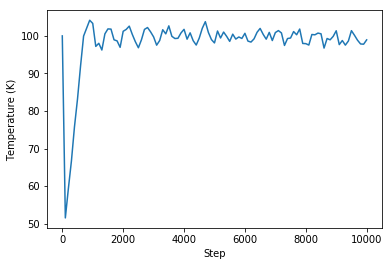

In [24]:
# Pull out data
steps = output.simulations[0]['thermo'].Step
temps = output.simulations[0]['thermo'].Temp

# Plot
plt.plot(steps, temps)
plt.xlabel('Step')
plt.ylabel('Temperature (K)')
plt.show()

Plot pressure vs. run step (note unit conversions)

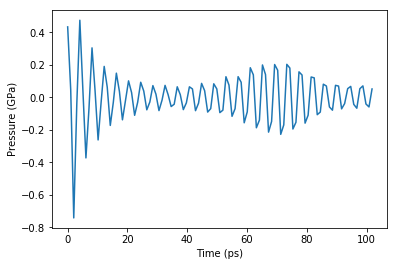

In [25]:
# Convert steps to time in atomman working units
steps = output.simulations[0]['thermo'].Step
time = uc.set_in_units(timestep, lammps_unit['time']) * steps

# Convert press to atomman working units
press = uc.set_in_units(output.simulations[0]['thermo'].Press, lammps_unit['pressure'])

# Plot in ps and GPa
plt.plot(uc.get_in_units(steps, 'ps'), uc.get_in_units(press, 'GPa'))
plt.xlabel('Time (ps)')
plt.ylabel('Pressure (GPa)')
plt.show()

## 8 Reading in dump files 

Finally, any dump files generated by the LAMMPS simulation can be loaded into atomman as Systems.  

In [26]:
system = am.load('atom_dump', '100000.dump', symbols='Al')
print(system.box)
print(system.atoms_df())

avect =  [12.186,  0.000,  0.000]
bvect =  [ 0.000, 12.186,  0.000]
cvect =  [ 0.000,  0.000, 12.186]
origin = [-0.018, -0.018, -0.018]
     atype     pos[0]     pos[1]     pos[2]  atom_id
0        1   0.022374  -0.053294  -0.046614        1
1        1   1.992035   2.057998  -0.041303        2
2        1   2.003978  -0.018609   2.049480        3
3        1   0.004959   1.932032   2.000017        4
4        1   3.970589   0.050074   0.023969        5
5        1   6.025744   2.034370  -0.061601        6
6        1   6.117310  -0.064136   1.992048        7
7        1   4.074024   2.038793   2.003295        8
8        1   8.029377  -0.055244  -0.036713        9
9        1  10.142793   2.021586   0.009183       10
10       1  10.167579  -0.082938   1.928802       11
11       1   8.087809   2.028606   1.995886       12
12       1  -0.087878   4.018785  -0.035485       13
13       1   2.024206   6.023807   0.048989       14
14       1   2.010619   3.988564   2.007256       15
15       1   0.0

**File Cleanup**

In [27]:
os.remove('Al.meam')
os.remove('library-Al.meam')
os.remove('2015--Pascuet-M-I--Al--LAMMPS--ipr1.json')
os.remove('Al-fcc.poscar')
os.remove('atom.dat')
os.remove('nvt.in')
os.remove('log.lammps')

# Remove dump files
flist = os.listdir(os.getcwd())
for fname in flist:
    if fname[-5:] == '.dump':
        os.remove(fname)       